<a href="https://colab.research.google.com/github/creamxia/Coursera_Capstone/blob/main/The_battle_of_Neighborhood_invest_a_property_in_New_York.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import necessary library

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

/bin/bash: conda: command not found
Libraries imported.


### Download neighborhood data of New York City.

In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

In [4]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [5]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

### Check the size of New York neighborhoods data.

In [6]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### Import housing price data of New York City.

In [7]:
url = 'https://raw.githubusercontent.com/creamxia/Coursera_Capstone/main/house%20price.csv'
houseprice_data = pd.read_csv(url)


### Merge the neighborhood data and the house price data into a dataframe.

In [8]:
nycPrice_data = pd.merge(neighborhoods, houseprice_data, on="Neighborhood")


In [9]:
nycPrice_data.drop(['Borough_y'], axis=1)
nycPrice_data.rename(columns={'Borough_x':'Borough'}, inplace=True)

### Remove data without houseprice.

In [10]:
nycPrice_data.dropna(subset=['Median List Price'],inplace=True)
nycPrice_data.shape

(206, 7)

### Use geopy library to get the latitude and longitude values of New York City.

In [11]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### Create a map of New York with neighborhoods superimposed on top.

In [12]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Define Foursquare Credentials and Version

In [18]:
#CLIENT_ID = 'J2YM5PEYF2K3OFQPCBV0JLAEJGSS21CLEOLE3A0XM3AN1KHS' # your Foursquare ID
#CLIENT_SECRET = 'LY5S2SXOM1ACQNAL22KJ5NVDJBNZAOHPRUWSF5FUK40L2USR' # your Foursquare Secret

CLIENT_ID = 'EJM4IOPXSJPYAXFAMJ0Z20QCU2T3Q5S0VGQE03LNY1LOZ0ZQ'
CLIENT_SECRET = '2NVWWRVVFEHY550GYBZVDSTASUJNKKY51SB4CIJD5N2RGJJ2'

VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EJM4IOPXSJPYAXFAMJ0Z20QCU2T3Q5S0VGQE03LNY1LOZ0ZQ
CLIENT_SECRET:2NVWWRVVFEHY550GYBZVDSTASUJNKKY51SB4CIJD5N2RGJJ2


### Explore Neighborhoods in New York. 

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
# Get the top (LIMIT) venues that are in the neighborhood within a radius of (radius) meters.
LIMIT = 100
radius = 2000


In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
newyork_venues = getNearbyVenues(names=nycPrice_data['Neighborhood'],
                                   latitudes=nycPrice_data['Latitude'],
                                   longitudes=nycPrice_data['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
Melrose
Mott Haven
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
Pelham Bay
Schuylerville
Castle Hill
Olinville
Pelham Gardens
Concourse
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
East New York
Canarsie
Flatlands
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Bergen Beach
Midwood
Chinatown
Washington Heights
Inwood
Central Harlem
East Harlem
Upper East Side
Upper West S

KeyError: ignored

In [ ]:
print(newyork_venues.shape)
newyork_venues.head()

In [ ]:
newyork_venues.groupby('Neighborhood').count()

In [ ]:
print('There are {} uniques categories.'.format(len(newyork_venues['Venue Category'].unique())))

### Analyze Each Neighborhood.

In [ ]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.head()

In [ ]:
newyork_onehot.shape

In [ ]:
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean().reset_index()
newyork_grouped

In [ ]:
newyork_grouped.shape

In [ ]:
num_top_venues = 5

for hood in newyork_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = newyork_grouped[newyork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In [ ]:
# sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

### Cluster Neighborhoods

In [ ]:
# set number of clusters
kclusters = 6

newyork_grouped_clustering = newyork_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

In [ ]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(newyork_grouped_clustering)
    kmeanModel.fit(newyork_grouped_clustering)
    distortions.append(sum(np.min(cdist(newyork_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / newyork_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

newyork_merged = nycPrice_data

# merge newyork_grouped with newyork_data to add latitude/longitude for each neighborhood
newyork_merged = newyork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

newyork_merged.head() # check the last columns!

In [ ]:
newyork_merged['Cluster Labels'] = newyork_merged['Cluster Labels'].astype(int)
newyork_merged['Median List Price'] = newyork_merged['Median List Price'].replace('[\$\,\.]', '', regex=True).astype(int)
newyork_merged.dtypes

In [ ]:
newyork_merged.drop('Borough_y',axis=1,inplace=True)
newyork_merged.head()
newyork_merged.shape

In [ ]:
newyork_merged


In [ ]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'],newyork_merged['Longitude'], newyork_merged['Neighborhood'], newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Binning housing price.
As for 6 clusters of neighborhoods in New York City, we also bin the price into 6 distinct values. 
('Low','Low-Medium''Medium','Medium-High','High','Extreme High')

AttributeError: ignored

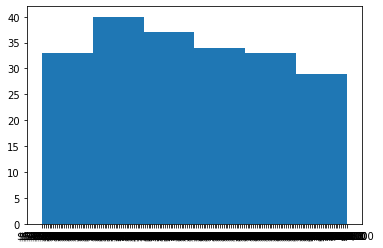

In [26]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(nycPrice_data["Median List Price"],bins=6)
plt.xticks(group_names)
# set x/y labels and plot title
plt.pyplot.xlabel("Median List Price")
plt.pyplot.ylabel("count")
plt.pyplot.title("Price level")

In [ ]:
bins = np.linspace(min(newyork_merged["Median List Price"]), max(newyork_merged["Median List Price"]), 7)
bins

In [22]:
group_names = ['Low','Low-Medium','Medium','Medium-High','High','Extreme High']

In [ ]:
newyork_merged['Price-Categories'] = pd.cut(newyork_merged["Median List Price"], bins, labels=group_names, include_lowest=True )
newyork_merged[['Median List Price','Price-Categories']].head()

### Create Choropleth map to visualize the clusters of neighborhoods in terms of housing price and cluster markers on the top.

In [ ]:
geojson_url = (
    "https://raw.githubusercontent.com/creamxia/Coursera_Capstone/main"
)
nyc_geo = f"{geojson_url}/nyc_neighborhoods.geojson"

geo_json_data = json.loads(requests.get(nyc_geo).text)

nyc_map = folium.Map(location = [latitude, longitude], zoom_start = 10)
folium.GeoJson(geo_json_data).add_to(nyc_map)

nyc_map.choropleth(
    geo_data=geo_json_data,
    data=newyork_merged,
    columns=['Neighborhood','Median List Price'],
    key_on='feature.properties.district',
    fill_color='BuPu', 
    fill_opacity=0.4, 
    line_opacity=0.2,
    legend_name='Median List Price'
)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'],newyork_merged['Longitude'], newyork_merged['Neighborhood'], newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.6).add_to(nyc_map)
       
# display map
nyc_map

In [ ]:
!pip install area
!pip install -U plotly 
import pandas as pd
import json
import math
import plotly.express as px
from area import area

# read the neighborhood population data into a DataFrame and load the GeoJSON data

df = pd.read_csv('https://data.cityofnewyork.us/api/views/swpk-hqdp/rows.csv?accessType=DOWNLOAD')
nycmap = geo_json_data

# create dictionary of nta codes mapping to area (square miles)
d = {}
p_neighborhood = nycmap["features"]
for n in p_neighborhood:
    code = n["properties"]["ntacode"]
    a = area(n["geometry"])/(1609*1609) # converts from m^2 to mi^2
    d[code] = a

# create new columns in df for area and density  
df["area"] = df["NTA Code"].map(d)
df = df.dropna(subset=["area"])
df["density"] = df["Population"]/df["area"]

# call Plotly Express choropleth function to visualize data
fig = px.choropleth_mapbox(df,
                           geojson=nycmap,
                           featureidkey='properties.ntacode',
                           locations="NTA Code",
                           color="density",
                           color_continuous_scale="viridis",
                           mapbox_style="carto-positron",
                           zoom=9, center={"lat": 40.7, "lon": -73.9},
                           opacity=0.7,
                           hover_name="NTA Name"
                           )

fig.show()

In [ ]:
fig_price = px.choropleth_mapbox(newyork_merged,
                           geojson=nycmap,
                           featureidkey="properties.ntaname",
                           locations="Neighborhood",
                           color="Median List Price",
                           color_continuous_scale="viridis",
                           mapbox_style="carto-positron",
                           zoom=9, center={"lat": 40.7, "lon": -73.9},
                           opacity=0.7,
                           hover_name="Neighborhood"
                           )

fig_price.show()

In [ ]:
newyork_merged.sort_values(by='Median List Price', ascending=False)

### Examine Clusters.

Cluster 1

In [ ]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 0, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

Cluster 2

In [ ]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 1, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

Cluster 3

In [ ]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 2, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

Cluster 4

In [ ]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 3, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

Cluster 5

In [ ]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 4, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

Cluster 6

In [ ]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 5, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

In [ ]:
cluster6 = newyork_merged.loc[newyork_merged['Cluster Labels'] == 5, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]
cluster6count = cluster6.value_counts('1st Most Common Venue').rename_axis('1st Most Common Venue').reset_index(name='counts')